In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#pip install torch torchvision matplotlib scikit-learn tqdm timm -q

In [8]:
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [9]:
# Paths
# train_dir = "/content/drive/MyDrive/DL/train"
# val_dir   = "/content/drive/MyDrive/DL/val"
# test_dir  = "/content/drive/MyDrive/DL/test"

base_dir = r"C:\Users\user\Desktop\DL"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

# Data transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# OPTIONAL: If you want to exclude one class (like "Melanocytic nevi")
exclude_class = "Melanocytic nevi"
if exclude_class in train_dataset.class_to_idx:
    exclude_idx = train_dataset.class_to_idx[exclude_class]
    from torch.utils.data import Subset
    train_indices = [i for i, (_, label) in enumerate(train_dataset.samples) if label != exclude_idx]
    val_indices = [i for i, (_, label) in enumerate(val_dataset.samples) if label != exclude_idx]
    test_indices = [i for i, (_, label) in enumerate(test_dataset.samples) if label != exclude_idx]
    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset, val_indices)
    test_dataset = Subset(test_dataset, test_indices)
    class_names = [cls for cls in datasets.ImageFolder(train_dir).classes if cls != exclude_class]
else:
    class_names = train_dataset.classes

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Class info
num_classes = len(class_names)
print(f"Classes ({num_classes}):", class_names)
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648
Val size: 1327
Test size: 2386


In [10]:
import torch
import torch.nn as nn
from collections import Counter

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Get labels from the train dataset ---
if isinstance(train_dataset, torch.utils.data.Subset):
    # For Subset, use the original dataset and indices
    labels = [train_dataset.dataset.samples[i][1] for i in train_dataset.indices]
else:
    labels = [y for _, y in train_dataset.samples]

# Compute class counts
counts = Counter(labels)
counts_list = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts_list)

# Compute class weights (inverse frequency)
class_weights = torch.tensor([sum(counts_list)/c for c in counts_list], dtype=torch.float).to(device)
print("Class weights:", class_weights)

# Define weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129])


In [23]:
# from torchvision.models import resnet50, ResNet50_Weights
# import torch.nn as nn

# # Load ResNet-50 with the latest API
# weights = ResNet50_Weights.DEFAULT  # or IMAGENET1K_V1
# model = resnet50(weights=weights)

# # Replace the final layer for your num_classes
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# # Move to device
# model = model.to(device)

from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights  # smaller version
import torch.nn as nn
import torch

# Load pretrained ResNet-18
weights = ResNet34_Weights.DEFAULT
model = resnet34(weights=weights)

# Freeze all convolutional layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:08<00:00, 10.1MB/s]


In [24]:
# import torch.optim as optim
# from torch.optim import lr_scheduler

# # Optimizer: Adam with weight decay
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# # Optional learning rate scheduler (uncomment if you want to use it)
# # StepLR: reduce LR by gamma every step_size epochs
# # scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# # Currently no scheduler
# scheduler = None

# # Number of training epochs
# num_epochs = 10  # start with 10; increase if model hasn't converged

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Optimizer - only trainable params
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,  # adjust as explained above
    weight_decay=1e-5
)

# Optional scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10


In [25]:
from sklearn.metrics import f1_score
import time, copy
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=10, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects / len(loader.dataset)
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")

        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val F1: {best_f1:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history


In [27]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    model_name="ResNet34"
)

Epoch 1/10


  0%|          | 0/333 [00:00<?, ?it/s]

  1%|          | 3/333 [00:14<25:47,  4.69s/it]


KeyboardInterrupt: 

In [28]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()

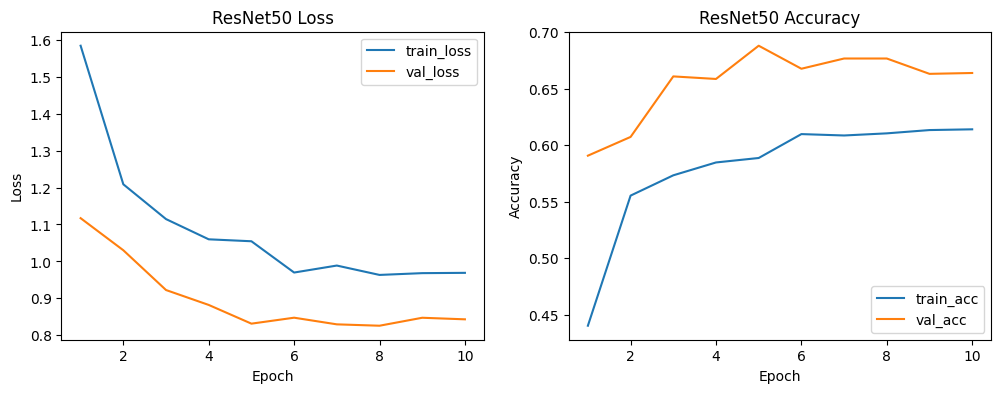

In [29]:
plot_history(history, model_name="ResNet50")

In [30]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

In [31]:

evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.78      0.62      0.69        86
             Chickenpox       0.52      0.68      0.59       112
                 Cowpox       0.49      0.77      0.60        99
         Dermatofibroma       0.46      0.52      0.49        23
                   HFMD       0.75      0.85      0.80       241
                Healthy       0.70      0.85      0.77       171
                Measles       0.73      0.50      0.59        82
              Monkeypox       0.83      0.53      0.65       426
Squamous cell carcinoma       0.49      0.69      0.58        62
       Vascular lesions       0.68      0.84      0.75        25

               accuracy                           0.68      1327
              macro avg       0.64      0.69      0.65      1327
           weighted avg       0.71      0.68      0.68      1327

Confusion matrix:
 [[ 53   0   0   7   0   0   0   0  23   3]
 [  0  76   8   0   6   4

In [32]:
# (place this in a new cell)
%pip install pandas
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

# Path to test data (same as training setup)
test_dir = os.path.join(base_dir, "test")

# Use same transforms as validation
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# Load best checkpoint
ckpt_path = "ResNet50_best.pth"   # corrected name
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print("Loaded checkpoint:", ckpt_path)
except Exception as e:
    print("Checkpoint load failed (using current model):", e)

model.to(device)
model.eval()

y_true, y_pred, probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# Metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# Save per-image predictions
filenames = [os.path.basename(p[0]) for p in test_dataset.samples]
df = pd.DataFrame({
    "file": filenames,
    "true": [class_names[i] for i in y_true],
    "pred": [class_names[i] for i in y_pred],
    "prob_top": [round(float(np.max(p)),4) for p in probs]
})
df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv")


     ---------------------------------------- 11.3/11.3 MB 6.9 MB/s eta 0:00:00
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Test classes order: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 2386
Checkpoint load failed (using current model): PytorchStreamReader failed reading zip archive: failed finding central directory

Classification Report:



ValueError: Number of classes, 13, does not match size of target_names, 10. Try specifying the labels parameter